<a href="https://colab.research.google.com/github/kirath2205/Neural-Network-Assignment-1/blob/pramurta/start_1b_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part B: Regression Problem**

In [ ]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization, StringLookup, IntegerLookup, Reshape

In [ ]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df.head()

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0


In [ ]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="one_hot") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


def encode_categorical_feature_for_embeddings(feature, name, dataset, is_string):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="int") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

# Question 1

**Part A**

Generally, the trend with HDB resale prices is that it gradually increases with increasing number of years. 

Now, if we randomly split the data, there is a chance that we might have a skewed representation of the data which can affect model performance. For example, 70% of our points could be from the year 2017. In this scenario, if the model has to make predictions on the resale prices in the year 2021, the model will lay more emphasis on the data in 2017 than data in 2020 or 2019 which are more recent and more relevant in predicting prices in 2021 than 2017. Therefore, the model will end up underestimating the resale price.


In [ ]:
#Split data
train_dataframe = df[df['year'] <= 2020] # 0.8393471285568813
val_dataframe = df[df['year'] > 2020]

train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

**Part B**

The cell below preprocesses the data by standardising the numerical features and performs one-hot encoding on the categorical features and then finally it concatenates the layers

In [ ]:
# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature(month, "month", train_ds, False)





# Categorical features encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature(storey_range, "storey_range", train_ds, True)


flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature(flat_model_type, "flat_model_type", train_ds, True)



# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)

#Concatenated features
all_features = layers.concatenate(
    [
        month_encoded,
        flat_model_type_encoded,
        storey_range_encoded,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]
)

#All input features
all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]




 The cell below represents a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer

In [ ]:
tf.keras.backend.clear_session()
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

Model Architecture

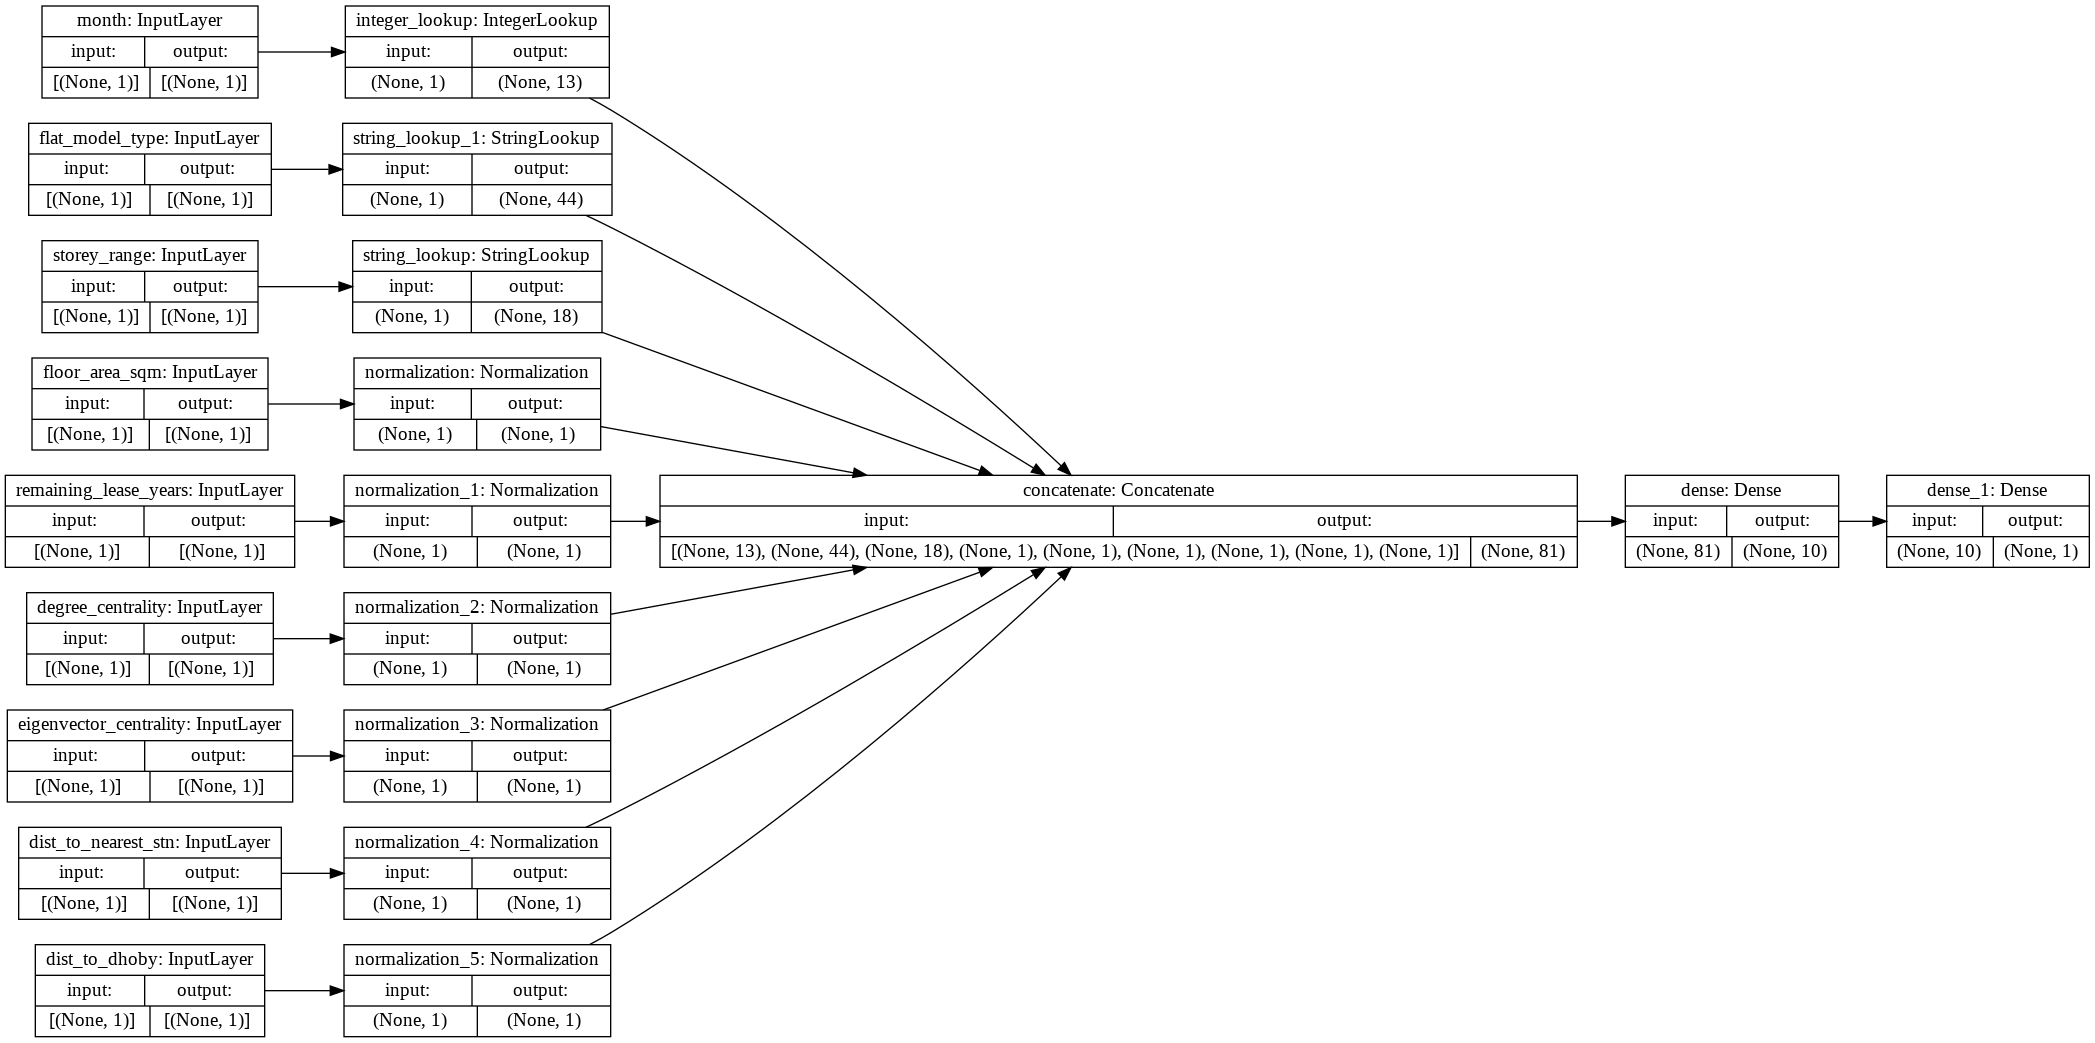

In [ ]:
model = keras.Model(all_inputs, output)
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

**Part C**

Model compilation

In [ ]:
from keras import backend as K

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

Model Summary

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
floor_area_sqm (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

Model Training

In [ ]:
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history = model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[model_checkpoint_callback])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 5s 5ms/step - loss: 187175714816.0000 - R2: -7.0488 - val_loss: 170701799424.0000 - val_R2: -5.6974
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 67175251968.0000 - R2: -1.8795 - val_loss: 39795949568.0000 - val_R2: -0.5496
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 10803833856.0000 - R2: 0.5421 - val_loss: 11000638464.0000 - val_R2: 0.5751
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 5527165440.0000 - R2: 0.7650 - val_loss: 8574937088.0000 - val_R2: 0.6689
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 4987610112.0000 - R2: 0.7872 - val_loss: 7978337792.0000 - val_R2: 0.6912
Epoch 6/100
683/683 [==============================] - 3s 4ms/step - loss: 4625724416.0000 - R2: 0.8025 - val_loss: 7678568960.0000 - val_R2: 0.7038
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 4363144192.0000 - R2: 0.8140 - 

**Part D**

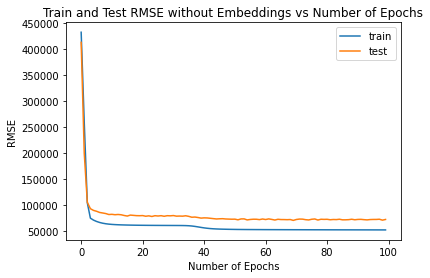

In [ ]:
import math
import matplotlib.pyplot as plt

history.history['root_mean_squared_error'] = []
history.history['val_root_mean_squared_error'] = []

for i in range(len(history.history['loss'])):
    history.history['root_mean_squared_error'].append(math.sqrt(history.history['loss'][i]))

for i in range(len(history.history['val_loss'])):
    history.history['val_root_mean_squared_error'].append(math.sqrt(history.history['val_loss'][i]))

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title("Train and Test RMSE without Embeddings vs Number of Epochs")
plt.ylabel('RMSE')
plt.xlabel('Number of Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


**Part E**

The cell below returns the epoch with the lowest test error. 

In [ ]:
test_loss = history.history['val_root_mean_squared_error']

min_epoch_loss_without_embedding = 0
min_loss_without_embedding = float("inf")
for i,loss in enumerate(test_loss):
    if loss<min_loss_without_embedding:
        min_loss_without_embedding = loss
        min_epoch_loss_without_embedding = i+1

print(min_epoch_loss_without_embedding)



70


Therefore, the **epoch with the lowest test error is 70**



In [ ]:
history.history['val_R2'][min_epoch_loss_without_embedding-1]

0.8073295950889587

R2 score at epoch 70 is: **0.8073295950889587**

**Part F**

Loading the weights from the saved model

In [ ]:
model.load_weights(checkpoint_filepath)

Extracting a batch comprising of 128 test samples and making predictions on them. 

In [39]:
iterator = iter(val_ds)
batch_size_of_128 = iterator.get_next()
del batch_size_of_128[0]['year']
del batch_size_of_128[0]['full_address']
del batch_size_of_128[0]['nearest_stn']
batch_size_of_128_predictions = model.predict(batch_size_of_128[0])
batch_size_of_128_true_values = batch_size_of_128[1]


Scatter plot between true and predicted values

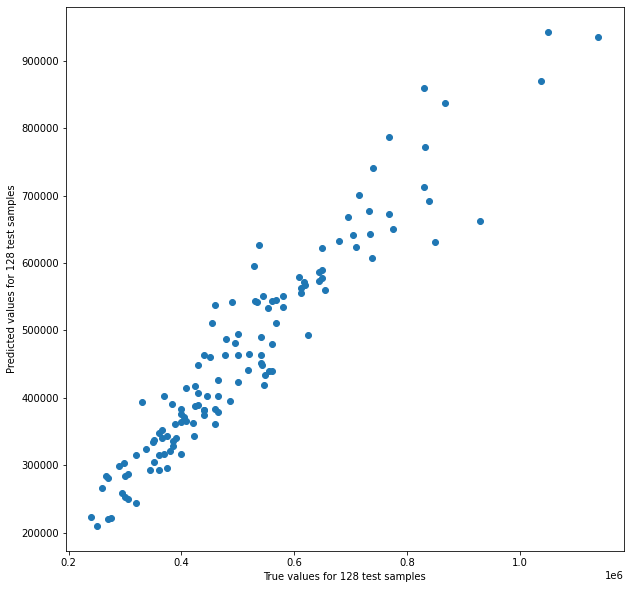

In [64]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.xlabel('True values for 128 test samples')
plt.ylabel('Predicted values for 128 test samples')
plt.scatter(batch_size_of_128_true_values, batch_size_of_128_predictions)

# Question 2

**Parts A and B**

The cell below preprocesses the data by encoding the numerical and further embedding and flattening the categorical features and finally, it concatenates all the layers

In [41]:
unique_month_counts = len(df['month'].value_counts())
unique_storey_range_counts = len(df['storey_range'].value_counts())
unique_flat_model_type_counts = len(df['flat_model_type'].value_counts())

In [42]:

# Categorical features encoded as integers
month = keras.Input(shape=(1,), name="month", dtype="int64")
month_encoded = encode_categorical_feature_for_embeddings(month, "month", train_ds, False)
month_embedder = tf.keras.layers.Embedding(input_dim = unique_month_counts+1, output_dim = (unique_month_counts//2), trainable=True)(month_encoded)
month_embedder_flattened = Reshape((-1,))(month_embedder)



# Categorical feature encoded as string

storey_range = keras.Input(shape=(1,), name="storey_range", dtype="string")
storey_range_encoded = encode_categorical_feature_for_embeddings(storey_range, "storey_range", train_ds, True)
storey_range_embedder = tf.keras.layers.Embedding(input_dim = unique_storey_range_counts+1, output_dim = (unique_storey_range_counts//2), trainable=True)(storey_range_encoded)
storey_range_embedder_flattened = Reshape((-1,))(storey_range_embedder)


flat_model_type = keras.Input(shape=(1,), name="flat_model_type", dtype="string")
flat_model_type_encoded = encode_categorical_feature_for_embeddings(flat_model_type, "flat_model_type", train_ds, True)
flat_model_type_embedder = tf.keras.layers.Embedding(input_dim = unique_flat_model_type_counts+1, output_dim = (unique_flat_model_type_counts//2), trainable=True)(flat_model_type_encoded)
flat_model_type_embedder_flattened = Reshape((-1,))(flat_model_type_embedder)




# Numerical features
floor_area_sqm = keras.Input(shape=(1,), name="floor_area_sqm")
floor_area_sqm_encoded = encode_numerical_feature(floor_area_sqm, "floor_area_sqm", train_ds)

remaining_lease_years = keras.Input(shape=(1,), name="remaining_lease_years")
remaining_lease_years_encoded = encode_numerical_feature(remaining_lease_years, "remaining_lease_years", train_ds)

degree_centrality = keras.Input(shape=(1,), name="degree_centrality")
degree_centrality_encoded = encode_numerical_feature(degree_centrality, "degree_centrality", train_ds)

eigenvector_centrality = keras.Input(shape=(1,), name="eigenvector_centrality")
eigenvector_centrality_encoded = encode_numerical_feature(eigenvector_centrality, "eigenvector_centrality", train_ds)

dist_to_nearest_stn = keras.Input(shape=(1,), name="dist_to_nearest_stn")
dist_to_nearest_stn_encoded = encode_numerical_feature(dist_to_nearest_stn, "dist_to_nearest_stn", train_ds)

dist_to_dhoby = keras.Input(shape=(1,), name="dist_to_dhoby")
dist_to_dhoby_encoded = encode_numerical_feature(dist_to_dhoby, "dist_to_dhoby", train_ds)


all_features = layers.concatenate(
    [
        month_embedder_flattened,
        flat_model_type_embedder_flattened,
        storey_range_embedder_flattened,
        floor_area_sqm_encoded,
        remaining_lease_years_encoded,
        degree_centrality_encoded,
        eigenvector_centrality_encoded,
        dist_to_nearest_stn_encoded,
        dist_to_dhoby_encoded
    ]
)

all_inputs = [
        month,
        flat_model_type,
        storey_range,
        floor_area_sqm,
        remaining_lease_years,
        degree_centrality,
        eigenvector_centrality,
        dist_to_nearest_stn,
        dist_to_dhoby
    ]




 The cell below represents a 2-layer feedforward neural network consisting of an input layer, a hidden layer (10 neurons, ReLU as activation function), and a linear output layer

In [43]:
# feedforward network with one hidden layer
tf.keras.backend.clear_session()
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

model2 = keras.Model(all_inputs, output)



Model Summary

In [44]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
month (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
flat_model_type (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
storey_range (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
integer_lookup (IntegerLookup)  (None, 1)            0           month[0][0]                      
______________________________________________________________________________________________

Model Architecture

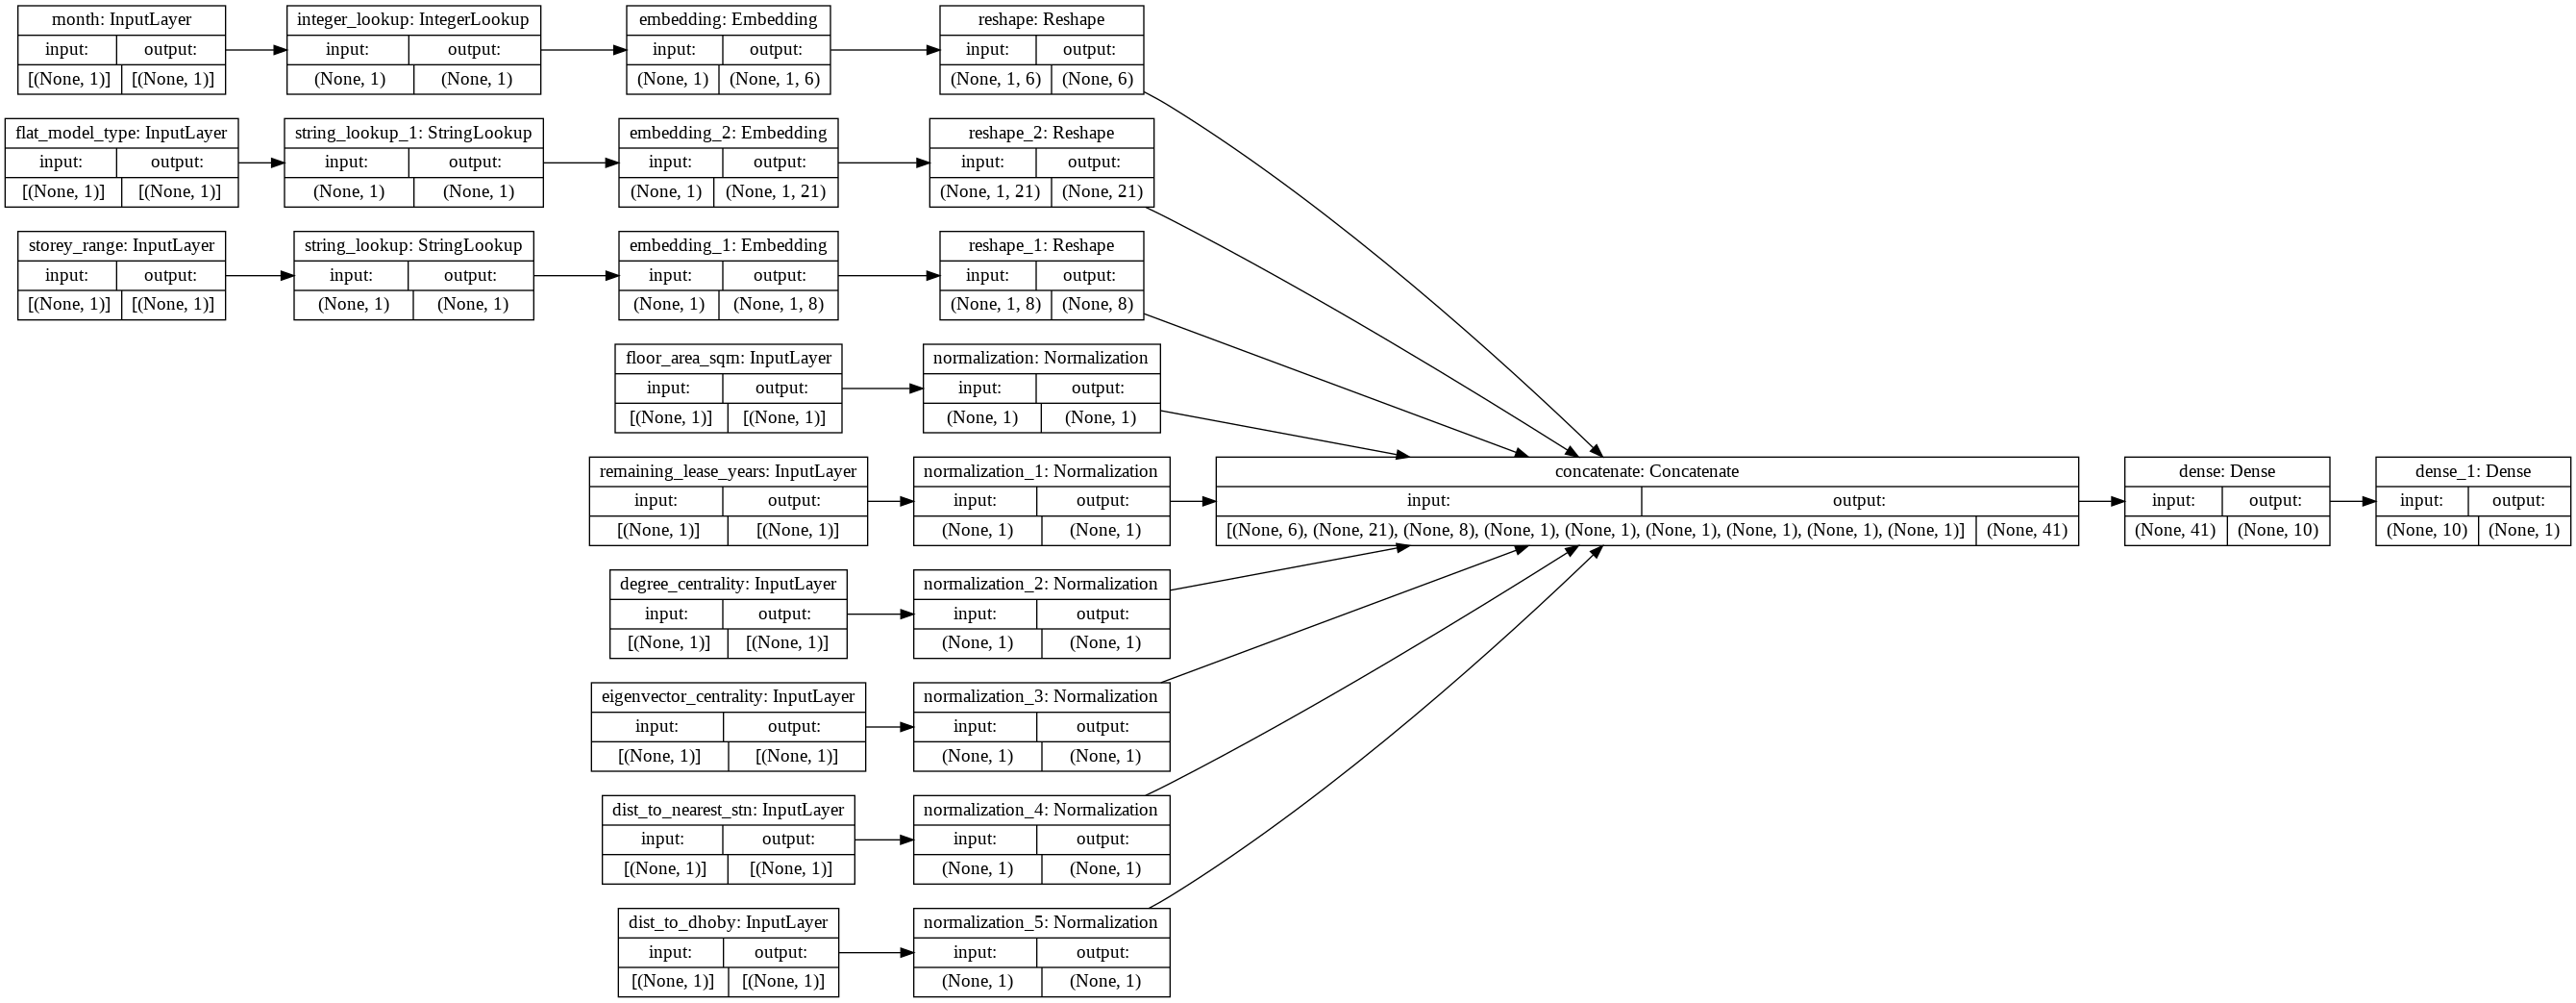

In [45]:
keras.utils.plot_model(model2, show_shapes=True, rankdir="LR")

Model Compilation

In [46]:
from keras import backend as K

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model2.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

In [47]:
history2 = model2.fit(train_ds, epochs=100, validation_data=val_ds)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 5ms/step - loss: 46453706752.0000 - R2: -1.0006 - val_loss: 11952965632.0000 - val_R2: 0.5401
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 8081560064.0000 - R2: 0.6548 - val_loss: 9835520000.0000 - val_R2: 0.6192
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 7014366208.0000 - R2: 0.6999 - val_loss: 8870029312.0000 - val_R2: 0.6576
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 6262458880.0000 - R2: 0.7318 - val_loss: 8415873024.0000 - val_R2: 0.6728
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 5589031936.0000 - R2: 0.7609 - val_loss: 7760495616.0000 - val_R2: 0.6986
Epoch 6/100
683/683 [==============================] - 3s 4ms/step - loss: 5084145152.0000 - R2: 0.7822 - val_loss: 7298959360.0000 - val_R2: 0.7164
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 4721801728.0000 - R2: 0.7976 - val_loss:

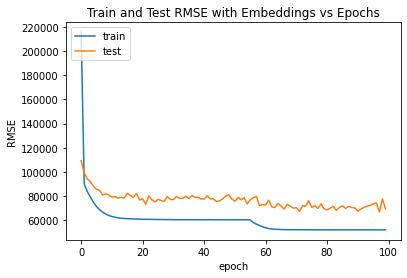

In [48]:
import math
import matplotlib.pyplot as plt

history2.history['root_mean_squared_error'] = []
history2.history['val_root_mean_squared_error'] = []

for i in range(len(history2.history['loss'])):
    history2.history['root_mean_squared_error'].append(math.sqrt(history2.history['loss'][i]))

for i in range(len(history2.history['val_loss'])):
    history2.history['val_root_mean_squared_error'].append(math.sqrt(history2.history['val_loss'][i]))

plt.plot(history2.history['root_mean_squared_error'])
plt.plot(history2.history['val_root_mean_squared_error'])
plt.title('Train and Test RMSE with Embeddings vs Epochs')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


**Part C**

In [49]:
test_loss = history2.history['val_root_mean_squared_error']

min_epoch_loss_with_embedding = 0
min_loss_with_embedding = float("inf")
for i,loss in enumerate(test_loss):
    if loss<min_loss_with_embedding:
        min_loss_with_embedding = loss
        min_epoch_loss_with_embedding = i+1

print("Best Epoch with Embedding: "+str(min_epoch_loss_with_embedding))
print("RMSE at the best epoch with Embedding: "+str(min_loss_with_embedding))
print("R2 value at the best epoch with Embedding: "+str(history2.history['val_R2'][min_epoch_loss_with_embedding-1]))
print("\n\n")
print("Best Epoch without Embedding: "+str(min_epoch_loss_without_embedding))
print("RMSE at the best epoch without Embedding: "+str(min_loss_without_embedding))
print("R2 value at the best epoch without Embedding: "+str(history.history['val_R2'][min_epoch_loss_without_embedding-1]))



Best Epoch with Embedding: 98
RMSE at the best epoch with Embedding: 66868.41622171113
R2 value at the best epoch with Embedding: 0.8243248462677002



Best Epoch without Embedding: 70
RMSE at the best epoch without Embedding: 70049.67745821533
R2 value at the best epoch without Embedding: 0.8073295950889587


Therefore, 

*   R2 score with embedding at best epoch > R2 score without embedding at best epoch
*   RMSE score with embedding at best epoch < RMSE score without embedding at best epoch



Therefore, from the above 2 conclusions we can clearly see that the model with Embeddings has performed better than the one without it at their best epochs. The reason behind this is that when we encode the categorical data in the form of an embedding matrix instead of a one-hot representation, more meaningful relationships can be discovered among the categories. For example, if there is a trend in the data that the prices of HDBs are high during few months, the embedding matrix can capture that piece of information by putting the embedding matrices of those months closer together than the others. 

# Question 3

**Part A**

Model definition and Compilation

In [77]:
tf.keras.backend.clear_session()
from keras import backend as K

# feedforward network with one hidden layer
x = layers.Dense(10, activation="relu")(all_features)
output = layers.Dense(1, activation="linear")(x)

model3 = keras.Model(all_inputs, output)

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model3.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])

Training the model with Early Stopping at a patience of 10 epochs

In [78]:
tf.keras.backend.clear_session()
history3 = model3.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 5ms/step - loss: 26116519936.0000 - R2: -0.1272 - val_loss: 11061901312.0000 - val_R2: 0.5689
Epoch 2/100
683/683 [==============================] - 4s 5ms/step - loss: 8191349760.0000 - R2: 0.6500 - val_loss: 9938854912.0000 - val_R2: 0.6140
Epoch 3/100
683/683 [==============================] - 4s 5ms/step - loss: 7622304768.0000 - R2: 0.6733 - val_loss: 9128294400.0000 - val_R2: 0.6451
Epoch 4/100
683/683 [==============================] - 4s 5ms/step - loss: 6762095104.0000 - R2: 0.7107 - val_loss: 10613306368.0000 - val_R2: 0.5885
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 5805903872.0000 - R2: 0.7518 - val_loss: 7376365568.0000 - val_R2: 0.7132
Epoch 6/100
683/683 [==============================] - 4s 5ms/step - loss: 5023720960.0000 - R2: 0.7847 - val_loss: 8189629952.0000 - val_R2: 0.6820
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 4527776256.0000 - R2: 0.8057 - val_loss

**Part B**

The cell below contains the function to build and train the model for part B

In [79]:
def build_and_train_model_question3(embeddings_list, epochs):
    all_features = layers.concatenate(embeddings_list)
    x = layers.Dense(10, activation="relu")(all_features)
    output = layers.Dense(1, activation="linear")(x)
    model = keras.Model(all_inputs, output)
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=[R2])
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10)])
    return history


RFE Implementation

In [80]:
import math
tf.keras.backend.clear_session()

scores = {}
history = {}

features_to_embeddings = {
    'month': month_embedder_flattened,
    'flat_model_type': flat_model_type_embedder_flattened,
    'storey_range': storey_range_embedder_flattened,
    'floor_area_sqm': floor_area_sqm_encoded,
    'remaining_lease_years': remaining_lease_years_encoded,
    'degree_centrality': degree_centrality_encoded,
    'eigenvector_centrality': eigenvector_centrality_encoded,
    'dist_to_nearest_stn': dist_to_nearest_stn_encoded,
    'dist_to_dhoby': dist_to_dhoby_encoded
}

initial_features = [
    'month',
    'flat_model_type',
    'storey_range',
    'floor_area_sqm',
    'remaining_lease_years',
    'degree_centrality',
    'eigenvector_centrality',
    'dist_to_nearest_stn',
    'dist_to_dhoby'           
]

def convert_features_list_to_embeddings(features_list):
    embeddings_list = []
    for feature in features_list:
        embeddings_list.append(features_to_embeddings[feature])
    return embeddings_list





def calculate_best_epoch_R2_and_RMSE(history):
    r2_scores = history.history['val_R2']
    mse = history.history['val_loss']
    best_epoch = 1
    for i in range(len(r2_scores)):
        if r2_scores[i]>r2_scores[best_epoch-1]:
            best_epoch = i+1
    return [r2_scores[best_epoch-1],math.sqrt(mse[best_epoch-1])]





def RFE(previous_r2_rmse_values,features_list, scores, depth):
    if not features_list or len(features_list)==1:
        return
    print(scores)
    max_r2_score_of_children_nodes = float("-inf")
    min_rmse_of_children_nodes = float("inf")
    max_features_list = []
    for i,feature in enumerate(features_list):
        new_features_list = features_list[:i]+features_list[i+1:]
        new_embeddings_list = convert_features_list_to_embeddings(new_features_list)
        tf.keras.backend.clear_session()
        history = build_and_train_model_question3(new_embeddings_list, 100)
        r2,rmse = calculate_best_epoch_R2_and_RMSE(history)
        scores[tuple(new_features_list)] = [r2,rmse]
        print(scores)
        if r2>=max_r2_score_of_children_nodes:
            max_r2_score_of_children_nodes = r2
            min_rmse_of_children_nodes = rmse
            max_features_list = new_features_list
    prev_r2, prev_rmse = previous_r2_rmse_values
    if depth>0 and max_r2_score_of_children_nodes<prev_r2: 
        return
    else:
        RFE([max_r2_score_of_children_nodes,min_rmse_of_children_nodes], max_features_list, scores, depth+1)
    
    

best_r2_and_rmse_score_all_features = calculate_best_epoch_R2_and_RMSE(history3)
scores[tuple(initial_features)] = best_r2_and_rmse_score_all_features
RFE(best_r2_and_rmse_score_all_features, initial_features, scores, 0)
print(scores)
    



{('month', 'flat_model_type', 'storey_range', 'floor_area_sqm', 'remaining_lease_years', 'degree_centrality', 'eigenvector_centrality', 'dist_to_nearest_stn', 'dist_to_dhoby'): [0.8194046020507812, 67845.04886872733]}
Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 5ms/step - loss: 26822531072.0000 - R2: -0.1555 - val_loss: 11200222208.0000 - val_R2: 0.5669
Epoch 2/100
683/683 [==============================] - 3s 5ms/step - loss: 8346531328.0000 - R2: 0.6432 - val_loss: 10540491776.0000 - val_R2: 0.5920
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 8021693440.0000 - R2: 0.6575 - val_loss: 10029662208.0000 - val_R2: 0.6105
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 7616962560.0000 - R2: 0.6743 - val_loss: 9944178688.0000 - val_R2: 0.6143
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 7032905216.0000 - R2: 0.6991 - val_loss: 9145555968.0000 - val_R2: 0.6451
Epoch 6/100
683/683 [==============================] - 3s 4ms/step - loss: 6314698240.0000 - R2: 0.7296 - val_loss: 7806337024.0000 - val_R2: 0.6978
Epoch 7/100
683/683 [==============================] - 3s 4ms/step - loss: 5655924224.0000 - R2: 0.7579 - val_los

In [81]:
total_features = [
    'month',
    'flat_model_type',
    'storey_range',
    'floor_area_sqm',
    'remaining_lease_years',
    'degree_centrality',
    'eigenvector_centrality',
    'dist_to_nearest_stn',
    'dist_to_dhoby'           
]
eliminated_features = []
r2_scores_list = []
root_mean_square_error_list = []

for feature_tuple in scores.keys():
    elim_feat=[]
    for feature in total_features:
        if feature not in feature_tuple:
            elim_feat.append(feature)
    if len(elim_feat)==0:
       eliminated_features.append("No features eliminated") 
    else:
        eliminated_features.append(elim_feat)
    r2_scores_list.append(scores[feature_tuple][0])
    root_mean_square_error_list.append(scores[feature_tuple][1])

In [82]:
rfe_table = pd.DataFrame(list(zip(eliminated_features , r2_scores_list , root_mean_square_error_list)) , columns=['Eliminated features','R2_Score','Root_Mean_Square_Error'])

In [83]:
%load_ext google.colab.data_table
# %reload_ext google.colab.data_table
rfe_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,Eliminated features,R2_Score,Root_Mean_Square_Error
0,No features eliminated,0.819405,67845.048869
1,[month],0.830965,65856.353741
2,[flat_model_type],0.771786,76396.111315
3,[storey_range],0.828244,66254.294110
4,[floor_area_sqm],0.829280,66063.908937
5,[remaining_lease_years],0.805453,70513.653713
6,[degree_centrality],0.838371,64245.327799
7,[eigenvector_centrality],0.836768,64679.168331
8,[dist_to_nearest_stn],0.808993,69914.950847
9,[dist_to_dhoby],0.694659,88498.237542


**Part C**

### Best R2 and RMSE values obtained in Q2 when we include **all the 9 features**: 

Best RMSE obtained in Q2: **66868.41622171113**

Best R2 value obtained in Q2: **0.8243248462677002**

### Best R2 and RMSE values is obtained in RFE when we eliminate **degree_centrality**:

Best RMSE obtained in RFE: **64245.32779899251**

Best R2 value obtained in RFE: **0.8383709192276001**






**Part D**

**Features and their usefulness:**



*   **Month:** According to the table shown above, when month was removed, the R2 value increased from 0.819 to 0.831. Moreover, when month was removed along with degree centrality, the R2 score was 0.828. **Therefore, month isn't a useful feature**

*   **Flat Model Type**: The table shown above clearly depicts that when the flat model type feature is removed the R2 value drops down to 0.77 from 0.819. **Therefore, flat model type is a very useful feature**

*   **Degree Centrality:** The table shown above clearly depicts that when degree centrality was removed, the R2 score was the highest(0.838). Moreover, degree centrality was removed the highest number of times in RFE. **Therefore, degree centrality is not a useful feature.** 

*   **Storey Range:** When Storey Range was removed, the R2 score improved slightly from 0.819 to 0.828. However, when storey range was removed along with degree centrality(unimportant feature), the R2 score dropped significantly from 0.819 to 0.80. **Therefore, storey range is a useful feature**

*   **Floor Area km:** The table shown above clearly depicts that when the Floor Area km feature is removed the R2 value improves from 0.819 to 0.829. **Therefore, floor area km is not a very useful feature**

*   **Remaining Lease Years:** The table shown above clearly depicts that when the Remaining Lease Years feature is removed the R2 value drops to 0.8 from 0.819. Also, when it is removed along with degree centrality(unimportant feature), the R2 value plummets down to 0.79 **Therefore, Remaining Lease Years is a very useful feature**




*   **Eigen Vector Centrality:** The table shown above clearly depicts that when eigen vector centrality was removed, the R2 score was the second highest(0.836). Moreover, eigen vector centrality was removed multiple number of times in RFE. **Therefore, eigen vector centrality is not a useful feature.**


*   **Dist_to_Dhoby:** The table shown above clearly depicts that when Dist_to_Dhoby was removed, the R2 score was the lowest(0.69).  **Therefore, dist_to_Dhoby is a very useful feature.**



*   **Dist_to_nearest_stn:** The table shown above clearly depicts that when the Dist_to_nearest_stn feature is removed the R2 value drops to 0.8 from 0.819. **Therefore, Dist_to_nearest_stn is a useful feature**

Hence, the 3 most unimportant features are: 


*   **Month**

*   **Degree Centrality**
*   **Eigen vector Centrality**




